In [1]:
import torch
import torch.nn as nn
import torch.functional as F
import numpy as np

from torchvision.datasets import mnist, cifar
import torchvision.transforms as transforms
from torch.utils.data import DataLoader


from torch.autograd import Variable
from torchvision.utils import make_grid
import matplotlib.pyplot as plt


In [2]:
class DataLoad():
    
    def __init__(self):
        pass
    
    def load_data_mnist(self, batch_size=128):
        
        mnist_data = mnist.MNIST(root = './data/mnist',
                                train = True,
                                download = True,
                                transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize([0.5],[0.5])]))
        
        mnist_loader = DataLoader(mnist_data, 
                                  batch_size = batch_size, 
                                  shuffle=True)
        
        return mnist_loader
    
    def load_data_cifar10(self, batch_size=128):
        
        cifar_data = cifar.CIFAR10(root = './data/cifar10',
                                  train = True,
                                  download = True,
                                  transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize([0.5],[0.5])]))
        
        cifar_loader = DataLoader(cifar_data,
                                  batch_size = batch_size,
                                  shuffle = True)
        
        return cifar_loader        

In [24]:
class Generator(nn.Module):
    
    def __init__(self, model_type, noise_dim=100):
        
        super(Generator, self).__init__()
        
        self.model_type = model_type
        self.image_shape = {'mnist': (1,28,28),
                           'cifar10': (3,32,32)}
        
        self.models = nn.ModuleDict({
            
            'mnist': nn.Sequential(
                            nn.Linear(noise_dim, 128, bias = True),
                            nn.LeakyReLU(0.2, inplace=True),
                            nn.Linear(128,256, bias = True),
                            nn.LeakyReLU(0.2, inplace=True),
                            nn.Linear(256,512, bias = True),
                            nn.LeakyReLU(0.2, inplace=True),
                            nn.Linear(512, 1024, bias=True),
                            nn.LeakyReLU(0.2, inplace=True),
                            nn.Linear(1024, int(np.prod(self.image_shape[model_type]))),
                            nn.Tanh()                
                            ),
            
            'cifar10': nn.Sequential(
                            nn.Linear(noise_dim, 128, bias = True),
                            nn.LeakyReLU(0.2, inplace=True),
                            nn.Linear(128,256, bias = True),
                            nn.LeakyReLU(0.2, inplace=True),
                            nn.Linear(256,512, bias = True),
                            nn.LeakyReLU(0.2, inplace=True),
                            nn.Linear(512, 1024, bias=True),
                            nn.LeakyReLU(0.2, inplace=True),
                            nn.Linear(1024, 2048, bias = True),
                            nn.LeakyReLU(0.2, inplace=True),
                            nn.Linear(2048, int(np.prod(self.image_shape[model_type]))),
                            nn.Tanh()                
                            ),
                })
        
    def forward(self, z):
        img = self.models[self.model_type](z)
        img = img.view(img.size(0), *self.image_shape[self.model_type])            
        return img

In [4]:
class Discriminator(nn.Module):
    
    def __init__(self, model_type):
        
        super(Discriminator, self).__init__()
        
        self.model_type = model_type
        self.image_shape = {'mnist': (1,28,28),
                           'cifar10': (3,32,32)}
        
        self.models = nn.ModuleDict({
            'mnist': nn.Sequential(
                            nn.Linear(int(np.prod(self.image_shape[model_type])),512),
                            nn.LeakyReLU(0.2, inplace=True),
                            nn.Linear(512,256),
                            nn.LeakyReLU(0.2, inplace=True),
                            nn.Linear(256,1),
                            nn.Sigmoid(),
                ),
            
            'cifar10': nn.Sequential(
                            nn.Linear(int(np.prod(self.image_shape[model_type])),1024),
                            nn.LeakyReLU(0.2, inplace=True),
                            nn.Linear(1024,512),
                            nn.LeakyReLU(0.2, inplace=True),
                            nn.Linear(512,256),
                            nn.LeakyReLU(0.2, inplace=True),
                            nn.Linear(256,1),
                            nn.Sigmoid(),
                ),
            })
    def forward(self, img):
        
        img_flat = img.view(img.size(0),-1)
        output = self.models[self.model_type](img_flat)
        
        return output

In [5]:
cuda = True if torch.cuda.is_available() else False
device = 'cuda' if cuda else 'cpu'

In [6]:
# Input arguments in this block
batch_size = 128
total_epochs = 100
dataset = 'cifar10'
learning_rate = 1e-4
beta1 = 0.5
beta2 = 0.999
noise_dim = 100
k = 4

folder_name = 'cifar_exp'
model_save_frequency = 20
image_sample_frequency = 20

In [7]:
fixed_noise = torch.randn(16, noise_dim, device=device)

In [ ]:
if not os.path.exist(folder_name):
    os.makedirs(folder_name)

In [8]:
def load_data(ds):
    
    # Initialize the dataloader
    data_loader = DataLoad()
    
    # Load training data into the dataloader
    if ds == 'mnist':
        train_loader = data_loader.load_data_mnist(batch_size = batch_size)
    elif ds == 'cifar10':
        train_loader = data_loader.load_data_cifar10(batch_size = batch_size)
    
    return train_loader



In [38]:
# Loss function

criterion = torch.nn.BCELoss()

# Initialize generator and discriminator

generator = Generator(dataset)
discriminator = Discriminator(dataset)

In [10]:
# Run this if you have a GPU

if cuda:
    generator.cuda()
    discriminator.cuda()
    criterion.cuda()

In [39]:
# Optimizers

optimizer_generator = torch.optim.Adam(generator.parameters(), lr = learning_rate, betas = (beta1, beta2))
optimizer_discriminator = torch.optim.Adam(discriminator.parameters(), lr = learning_rate, betas = (beta1, beta2))


In [12]:
# Set real/fake designations:

real = float(1)
fake = float(0)

In [53]:
dataset

'cifar10'

In [30]:
# Load training data:

train_loader = load_data(dataset)

Files already downloaded and verified


In [42]:
# Training Loop

for epoch in range(total_epochs):
    # update the discriminator k times before updating the generator
    for i, (imgs, _) in enumerate(train_loader):
        
        
        
        imgs = imgs.to(device)
        
        valid = Variable(torch.Tensor(imgs.size(0),1).fill_(real), requires_grad=False).to(device)
        false = Variable(torch.Tensor(imgs.size(0),1).fill_(fake), requires_grad=False).to(device)
        
        optimizer_discriminator.zero_grad()
        
        # Calculate the loss on the all-real batch
        real_loss = criterion(discriminator(imgs), valid)
        
        # Generate some random noise        
        noise = Variable(torch.Tensor(np.random.normal(0,1, (imgs.shape[0], noise_dim)))).to(device)
        
        # Generate fake images by putting random noise through the generator function
        gen_imgs = generator(noise)
        
        # Classify the generated images with the discriminator and then calculate loss on the all-fake batch
        fake_loss = criterion(discriminator(gen_imgs), false)
        
        # Add the gradients from the all-real and all-fake batches
        
        loss_D = real_loss + fake_loss # Maybe leave this blank?
        
        # Calculate the gradients        
        loss_D.backward()
        
        # Update D
        optimizer_discriminator.step()
        
        
        # Update generator network: maximize log(D(G(z)))
        # This only fires after k steps of discriminator optimization
        
    if (epoch+1)%k == 0:
        optimizer_generator.zero_grad()

        # fake labels are real for generator cost
        # Since we just updated our discriminator, we need to do another forward pass of an all-fake batch
        # through our discriminator

        gen_imgs = generator(noise)
        output = discriminator(gen_imgs)

        # Now we need to calculate the probability of the discriminator classifying the fake images as real
        # If this probability is close to 0, then the generator has learnt how to fool the discriminator

        D_x = output.mean().item()

        # Calculate the generator's loss based on this

        loss_G = criterion(output, valid)

        # Calculate gradients for the generator:
        optimizer_generator.step()

        # Output the training stats
        print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\t'
                % (epoch+1, total_epochs, 
                   i+1, len(train_loader),
                   loss_D.item(),
                   loss_G.item(),
                   D_x))
            
    if (epoch+1) % image_sample_frequency == 0:
        with torch.no_grad():
            fake_sample = generator(fixed_noise)
            image_grid = make_grid(fake_sample.to(device),
                                   padding=2,
                                   nrow=4,
                                   normalize = True)
            plt.imshow(image_grid.permute(1,2,0))
            plt.axis('off')

KeyboardInterrupt: 

(-0.5, 137.5, 137.5, -0.5)

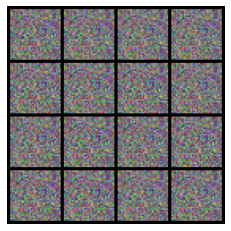

In [41]:
fake_sample = generator(fixed_noise)
image_grid = make_grid(fake_sample.to(device),
                                       padding=2,
                                       nrow=4,
                                       normalize = True)
plt.imshow(image_grid.permute(1,2,0))
plt.axis('off')

In [35]:
enumerate(train_loader)